# Movie Genres Classification

<img src="./type-of-movi.jpg">

## Objective : Predicting genre of movies from first 1000 chrarcters of script.

In [59]:
#Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params,palette='pastel')
#NLP Libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

## Load The Dataset

In [60]:
df_train = pd.read_csv('movie_train.csv',index_col='id')
df_test = pd.read_csv('movie_test.csv',index_col='id')

In [61]:
df_train

,text,genre
id,,
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
2,"t, summa cum laude and all. And I'm about to l...",comedy
3,"up Come, I have a surprise.... She takes him ...",drama
4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
5,"nd dismounts, just as the other children reach...",drama
...,...,...
28161,n in the world to decide what I'm going to do ...,drama
28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller


In [62]:
df_test

,text
id,
1,glances at her. BOOK Maybe I ought to learn t...
8,hout breaking stride. Tatiana sees her and can...
13,dead bodies. GEORDI Mitchell... DePaul... LANG...
24,take myself. BRANDON How bad is the other thi...
38,"her body to shield his own. KAY Freeze it, Bug..."
...,...
28140,Crazy Love script by Carol Watson COMMITTED f...
28142,"break? You folks don't need a break, you need..."
28154,egain control of his battered psyche. LIVIA Ca...


## Exploratory Data Analysis

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22579 entries, 0 to 28166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22579 non-null  object
 1   genre   22579 non-null  object
dtypes: object(2)
memory usage: 529.2+ KB


### Shape of Dataset

In [64]:
df_train.shape

(22579, 2)

### Columns in dataset

In [65]:
df_train.columns

Index(['text', 'genre'], dtype='object')

### Columns Data type

In [66]:
df_train.dtypes

text     object
genre    object
dtype: object

### Null Values in Dataset

In [67]:
df_train.isna().sum()

text     0
genre    0
dtype: int64

### First 5 rows of dataset

In [68]:
df_train.head()

,text,genre
id,,
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
2,"t, summa cum laude and all. And I'm about to l...",comedy
3,"up Come, I have a surprise.... She takes him ...",drama
4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
5,"nd dismounts, just as the other children reach...",drama


### What are the number of movies in different genre ?

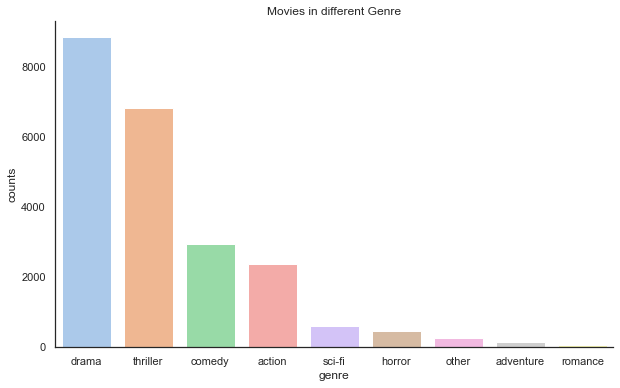

In [69]:
genre_counts = df_train['genre'].value_counts().rename_axis('genre').to_frame('counts').reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=genre_counts,x='genre',y='counts')
plt.title('Movies in different Genre');

* Most of the movies are from drama, thriller,comedy and action genre

## Data Preprocessing

### Label Encoding Genre Column

In [70]:
le = LabelEncoder()

In [71]:
le.fit(df_train['genre'])

LabelEncoder()

In [72]:
le.classes_

array(['action', 'adventure', 'comedy', 'drama', 'horror', 'other',
       'romance', 'sci-fi', 'thriller'], dtype=object)

In [73]:
df_train['genre'] = le.transform(df_train['genre'])

#### Genre after label encoding

In [74]:
df_train

,text,genre
id,,
0,"eady dead, maybe even wishing he was. INT. 2ND...",8
2,"t, summa cum laude and all. And I'm about to l...",2
3,"up Come, I have a surprise.... She takes him ...",3
4,ded by the two detectives. INT. JEFF'S APARTME...,8
5,"nd dismounts, just as the other children reach...",3
...,...,...
28161,n in the world to decide what I'm going to do ...,3
28162,shards. BOJO LAZ! Laz pushes Deke back through...,3
28163,"OTTIE You've got a thing about Ernie's, haven'...",8


### Removing special characters from the text

In [75]:
def text_only(text):
    cleaned = re.compile(r'[^a-zA-Z]')
    return re.sub(cleaned,' ',text)

In [76]:
df_train['text'] = df_train['text'].apply(text_only)

In [77]:
df_train.head()

,text,genre
id,,
0,eady dead maybe even wishing he was INT ND...,8
2,t summa cum laude and all And I m about to l...,2
3,up Come I have a surprise She takes him ...,3
4,ded by the two detectives INT JEFF S APARTME...,8
5,nd dismounts just as the other children reach...,3


### Change text to lower case

In [78]:
df_train['text'] = df_train['text'].apply(lambda text:text.lower())

### Stpowords Removing

In [79]:
stop_words = set(stopwords.words('english'))
def rem_stopwords(text,stopword_list=stop_words):
    for w in text:
        if w in stopword_list:
            text.replace(w,'')
    return text

In [80]:
df_train['text'] = df_train['text'].apply(rem_stopwords)

### Stemming words with port stemmer

In [81]:
def word_stemmer(text,ps = PorterStemmer()):
    for w in text:
        text.replace(w,ps.stem(w))
    return text

In [82]:
df_train['text'] = df_train['text'].apply(word_stemmer)

In [83]:
print(df_train['text'].iloc[0])

eady dead  maybe even wishing he was  int   nd floor hallway three night the orderly leads liza to a door  orderly in here  white guy in his   s  he opens the door and they step into    room three there s a white guy in his mid   s  he looks up  wild  straight jacketed  not jerry  liza s reached the end of her rope  she just shakes her head  int  decrepit hospital room night balled up  fetal  not really all there  head pressed to the cement  he tries to sing to himself  jerry blue moon    blue moon    int   nd floor hallway three night liza just stands there  leaning on a rail on the wall  the orderly isn t sure what s going on  but he knows it s bad  orderly you okay  liza starts down the hall with the orderly following  orderly we got some new patients last week  you want to see them  liza waves them off  it s hopeless  she stops at a chicken wired window at the end of the hall  looks out  light s about to break and jerry s out there somewhere  orderly look  i gotta get back to work 

In [84]:
print(df_train['text'].iloc[2])

 up come  i have a surprise     she takes him by the hand and leads him out to the hallway  salvatore looks at her and feels a pang  she seems smaller  age withers the body  she is slightly stooped  her hair is gathered into a knot at the back other head  you must be tired  if you want to rest  there s time before the funeral  salvatore interrupting her no  mamma  it only takes an hour by air  you know  maria smiling  ironically you shouldn t tell me that now  after all these years  salvatore gets the message  feels guilty  thinking about it  it seems incredible that he has never come before  maria opens a door  steps aside to let her son in  whispers i put all your things in here  go in  go in    salvatore lakes a few steps  is flabbergasted at the sight of his old room perfectly reconstructed and preserved  it looks like a museum  the museum of the past  despite the bed  the clothes in the cupboard  the books on the shelves  it is perfectly clear that no one has ever lived in it and 

### Splitiing input and  target columns

In [85]:
# Creating the Bag of Words model
cv = CountVectorizer(max_features=10000, ngram_range=(1,2))
X = cv.fit_transform(df_train['text']).toarray()

In [86]:
y = df_train['genre']

### Splitting data into train and test set

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Machine Learning Modeling

### Multinomial Naive Bayes

In [88]:
mnb = MultinomialNB()

In [89]:
# Model Training
mnb.fit(X_train,y_train)

MultinomialNB()

### Naive Bayes Model Evaluation

In [90]:
def model_eval(clf, X_train, y_train, X_test, y_test, train_score=True):
    if train_score:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train_score==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

### Scores

In [91]:
# Train Scores
model_eval(mnb, X_train, y_train, X_test, y_test, train_score=True)

Train Result:
Accuracy Score: 86.86%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1            2            3           4  \
precision     0.796744    0.903704     0.864887     0.914828    0.568966   
recall        0.943721    1.000000     0.899393     0.829811    0.975806   
f1-score      0.864027    0.949416     0.881803     0.870248    0.718812   
support    1919.000000  122.000000  2306.000000  7145.000000  372.000000   

                    5          6           7            8  accuracy  \
precision    0.948837   0.892857    0.776730     0.887593  0.868626   
recall       1.000000   0.980392    0.974359     0.853964  0.868626   
f1-score     0.973747   0.934579    0.864392     0.870454  0.868626   
support    204.000000  51.000000  507.000000  5437.000000  0.868626   

              macro avg  weighted avg  
precision      0.839461      0.876957  
recall         0.939716      0.868626  
f1-score       0.880831      0.8697

In [92]:

# Test Scores
model_eval(mnb, X_train, y_train, X_test, y_test, train_score=False)

Test Result:
Accuracy Score: 83.17%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1           2            3          4  \
precision    0.747387   0.851852    0.822804     0.876002   0.464968   
recall       0.906977   0.920000    0.840945     0.821759   0.869048   
f1-score     0.819484   0.884615    0.831776     0.848014   0.605809   
support    473.000000  25.000000  635.000000  1728.000000  84.000000   

                   5          6           7            8  accuracy  \
precision   0.937500   0.916667    0.635714     0.878145  0.831709   
recall      0.909091   0.916667    0.839623     0.805335  0.831709   
f1-score    0.923077   0.916667    0.723577     0.840165  0.831709   
support    66.000000  12.000000  106.000000  1387.000000  0.831709   

             macro avg  weighted avg  
precision     0.792338      0.843297  
recall        0.869938      0.831709  
f1-score      0.821465      0.834388  
support    4516.000000   

### Hyperparameter Tunning Finding Best Value of ALPHA

In [95]:
def best_alpha(alpha_list,X_train,y_train,X_test,y_test):
    train_accuracy = []
    test_accuracy = []
    alpha_val = []
    for i in tqdm(alpha_list):
        temp_classifier = MultinomialNB(alpha=i)
        temp_classifier.fit(X_train, y_train)
        temp_ytrain_pred = temp_classifier.predict(X_train)
        temp_ytest_pred = temp_classifier.predict(X_test)
        alpha_val.append(i)
        train_accuracy.append(accuracy_score(y_train, temp_ytrain_pred))
        test_accuracy.append(accuracy_score(y_test, temp_ytest_pred))
    plt.plot(alpha_val,train_accuracy, color='r',marker='o')  
    plt.plot(alpha_val,test_accuracy, color='b',marker='o')
    plt.legend(['Train Accu','Test Accu'])
    plt.title('Train and Test Accuracy with Different Alpha')



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:49<00:00, 46.92s/it]


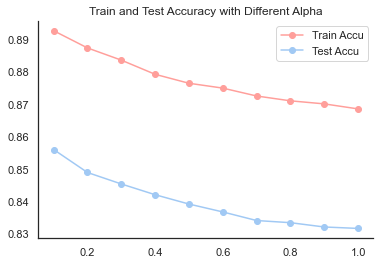

In [96]:
alpha_list = np.arange(0.1,1.1,0.1)
best_alpha(alpha_list,X_train,y_train,X_test,y_test)

### Multinomial Naive Bayes with alpha=0.1

In [97]:
mnb2 = MultinomialNB(alpha=0.1)

In [106]:
# Model Training
mnb2.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

## Saving Model And Parameters

In [107]:
import joblib

In [108]:
params ={
    'model':mnb2,
    'count_vect':cv,
    'label_encoder':le    
}

In [109]:
joblib.dump(params,'movie_classifier.joblib')

['movie_classifier.joblib']

## Predicting Genre for test dataset

In [112]:
ps = PorterStemmer()
def pred_genre(text):
    script = re.sub(pattern='[^a-zA-Z]',repl=' ', string=text)
    script = script.lower()
    script_words = script.split()
    sample_script_words = [word for word in script_words if not word in set(stopwords.words('english'))]
    final_script = [ps.stem(word) for word in script_words]
    final_script = ' '.join(final_script)
    bow = cv.transform([final_script]).toarray()
    pred = mnb2.predict(bow)
    pred = le.inverse_transform(pred)
    return pred[0]

In [118]:
genre=[]
for script in tqdm(df_test['text'].values):
    predicted_genre = pred_genre(script)
    genre.append(predicted_genre)
#
df_test['genre']=genre

100%|██████████████████████████████████████████████████████████████████████████████| 5589/5589 [06:36<00:00, 14.10it/s]


In [119]:
df_test

,text,genre
id,,
1,glances at her. BOOK Maybe I ought to learn t...,drama
8,hout breaking stride. Tatiana sees her and can...,drama
13,dead bodies. GEORDI Mitchell... DePaul... LANG...,thriller
24,take myself. BRANDON How bad is the other thi...,thriller
38,"her body to shield his own. KAY Freeze it, Bug...",action
...,...,...
28140,Crazy Love script by Carol Watson COMMITTED f...,drama
28142,"break? You folks don't need a break, you need...",comedy
28154,egain control of his battered psyche. LIVIA Ca...,drama


In [120]:
df_test.to_csv('test_predicted.csv')